In [2]:
# import libraries
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D,BatchNormalization,Activation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
import random
import os



In [ ]:
# Load data from google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to your train and test directory
#train_dir = r'/content/drive/MyDrive/Malaria parasite images/Train'
#test_path = r'/content/drive/MyDrive/Malaria parasite images/Test'

# Path to your train and test directory
train_dir = r'C:\Users\OMEN\MP_Detect\Train'
test_path = r'C:\Users\OMEN\MP_Detect\Test'

In [4]:
# Specify parameters for batch size, image height and width
batch_size = 32
img_height = 128
img_width = 128

In [5]:
# Load training Dataset with validation split
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="training",
    seed=152,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    class_names=['infected', 'uninfected']
)

# Load validation Dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=152,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary',
    class_names=['infected', 'uninfected']
)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


In [6]:
def check_class_balance(dataset):
    infected_count = 0
    uninfected_count = 0
    total = 0
    for images, labels in dataset:
        total += len(labels)
        infected_count += tf.reduce_sum(labels)
        uninfected_count += len(labels) - tf.reduce_sum(labels)
    print(f"Total samples: {total}")
    print(f"Infected samples: {infected_count} ({infected_count/total:.2%})")
    print(f"Uninfected samples: {uninfected_count} ({uninfected_count/total:.2%})")

check_class_balance(train_ds)
check_class_balance(val_ds)

Total samples: 22047
Infected samples: 11047.0 (50.11%)
Uninfected samples: 11000.0 (49.89%)
Total samples: 5511
Infected samples: 2732.0 (49.57%)
Uninfected samples: 2779.0 (50.43%)


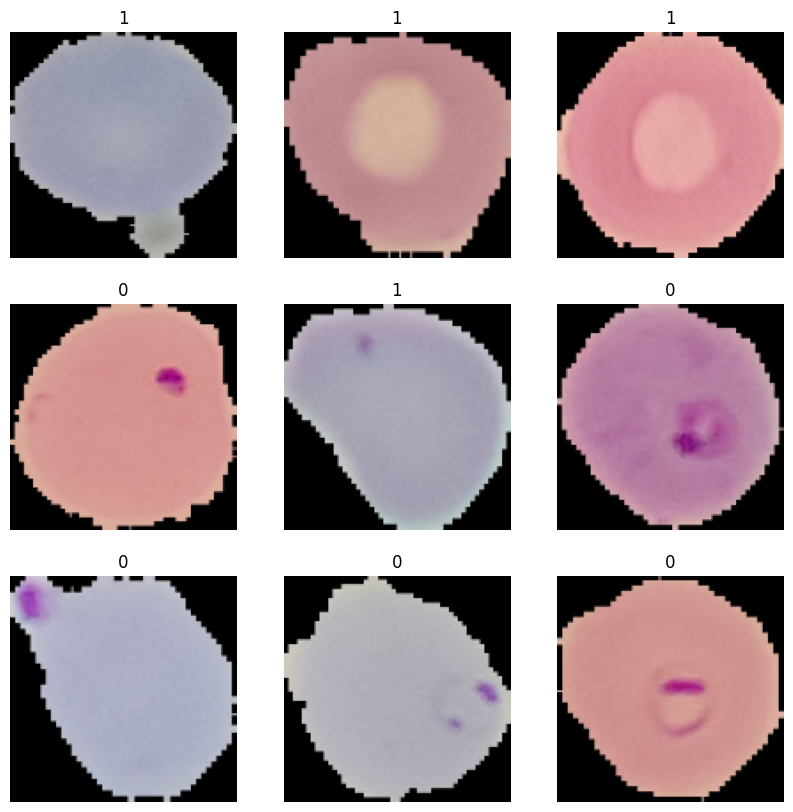

In [7]:
# Visualise the Training Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

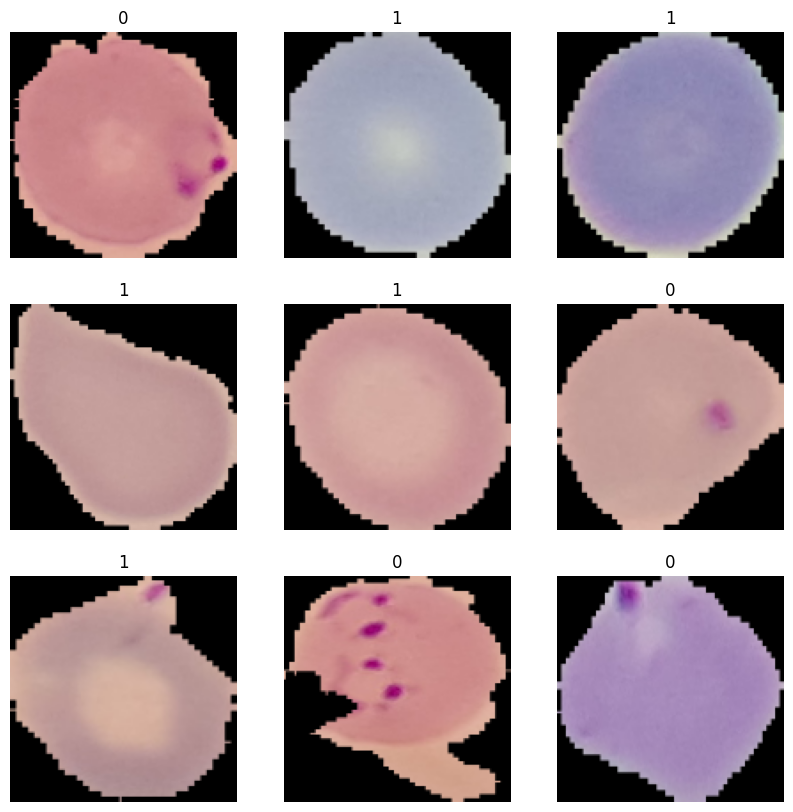

In [8]:
# Visualise the Validation Dataset
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

In [9]:
def check_data_range(dataset):
    for images, labels in dataset.take(1):
        print(f"Before normalization - Min: {tf.reduce_min(images)}, Max: {tf.reduce_max(images)}")
        normalized_images = tf.cast(images, tf.float32) / 255.0
        print(f"After normalization - Min: {tf.reduce_min(normalized_images)}, Max: {tf.reduce_max(normalized_images)}")
        print(f"Labels - Min: {tf.reduce_min(labels)}, Max: {tf.reduce_max(labels)}")

print("Training dataset:")
check_data_range(train_ds)
print("\nValidation dataset:")
check_data_range(val_ds)

Training dataset:
Before normalization - Min: 0.0, Max: 237.79296875
After normalization - Min: 0.0, Max: 0.9325214624404907
Labels - Min: 0.0, Max: 1.0

Validation dataset:
Before normalization - Min: 0.0, Max: 236.31210327148438
After normalization - Min: 0.0, Max: 0.9267141222953796
Labels - Min: 0.0, Max: 1.0


In [10]:
def preprocess_data(image, label):
    # Rescale the image to [0, 1] range
    image = tf.cast(image, tf.float32)
    image = (image - tf.reduce_min(image)) / (tf.reduce_max(image) - tf.reduce_min(image))
    return image, label

# Apply preprocessing to both datasets
train_ds = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

# Check the new data range
def check_data_range(dataset):
    for images, labels in dataset.take(1):
        print(f"Images - Min: {tf.reduce_min(images)}, Max: {tf.reduce_max(images)}")
        print(f"Labels - Min: {tf.reduce_min(labels)}, Max: {tf.reduce_max(labels)}")

print("Training dataset:")
check_data_range(train_ds)
print("\nValidation dataset:")
check_data_range(val_ds)

Training dataset:
Images - Min: 0.0, Max: 1.0
Labels - Min: 0.0, Max: 1.0

Validation dataset:
Images - Min: 0.0, Max: 1.0
Labels - Min: 0.0, Max: 1.0


In [ ]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds  = val_ds .cache().prefetch(buffer_size=AUTOTUNE)


# Enhanced data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])


In [ ]:
def create_complex_model(input_shape=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_shape)

    # Data augmentation layer
    x = data_augmentation(inputs)

    # First Convolutional Block
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Second Convolutional Block
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Third Convolutional Block
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    # Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Create the model
model = create_complex_model()

# Display model summary
model.summary()

In [ ]:
# Training the model
history = model.fit(
    train_ds,
    epochs=50,
    validation_data=val_ds,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001)
    ]
)

Epoch 1/20
690/690 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.8101
Epoch 1
Training Accuracy: 0.8101
Training Loss: 0.4026
Validation Accuracy: 0.9342
Validation Loss: 0.1867
Learning Rate: 0.001000
690/690 [==============================] - 96s 137ms/step - loss: 0.4026 - accuracy: 0.8101 - val_loss: 0.1867 - val_accuracy: 0.9342 - lr: 0.0010
Epoch 2/20
690/690 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9397
Epoch 2
Training Accuracy: 0.9397
Training Loss: 0.1820
Validation Accuracy: 0.9476
Validation Loss: 0.1586
Learning Rate: 0.001000
690/690 [==============================] - 96s 138ms/step - loss: 0.1820 - accuracy: 0.9397 - val_loss: 0.1586 - val_accuracy: 0.9476 - lr: 0.0010
Epoch 3/20
690/690 [==============================] - ETA: 0s - loss: 0.1595 - accuracy: 0.9485
Epoch 3
Training Accuracy: 0.9485
Training Loss: 0.1595
Validation Accuracy: 0.9538
Validation Loss: 0.1442
Learning Rate: 0.001000
690/690 [=============

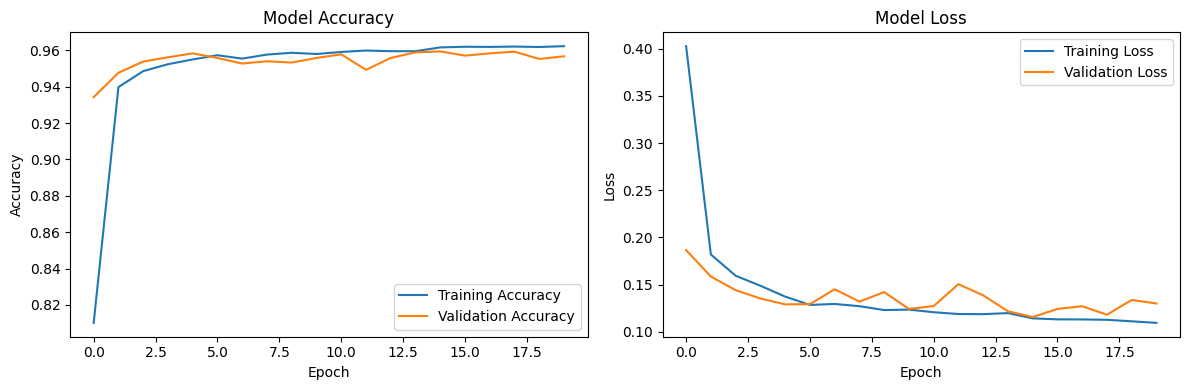

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



Processing image: C39P4thinF_original_IMG_20150622_105803_cell_112.png


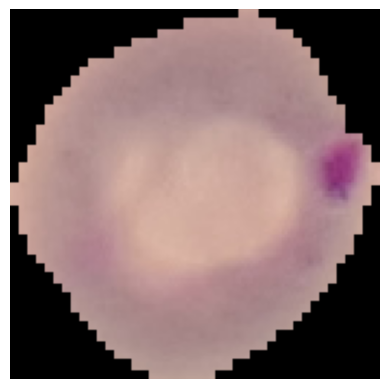

1/1 [==============================] - 0s 30ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_220.png


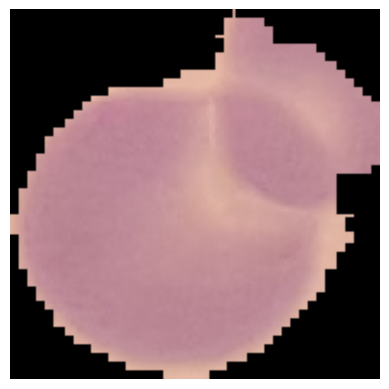

1/1 [==============================] - 0s 29ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_86.png


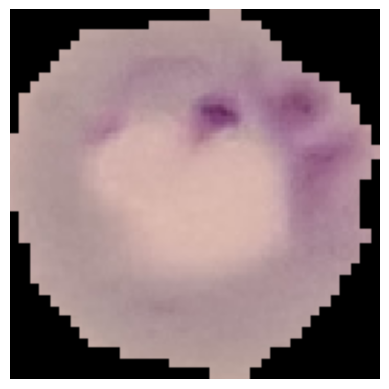

1/1 [==============================] - 0s 26ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_101.png


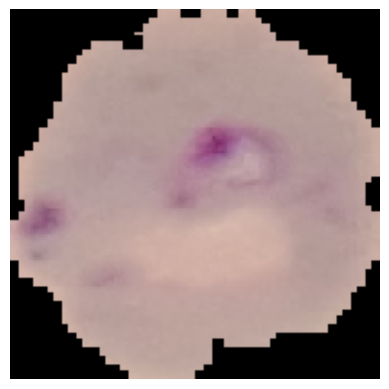

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_81.png


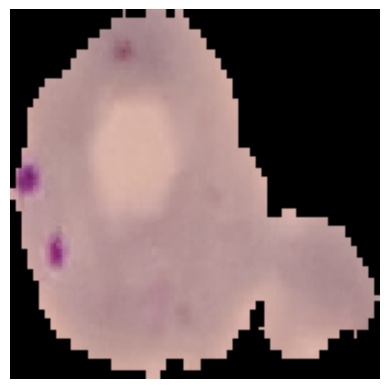

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_121.png


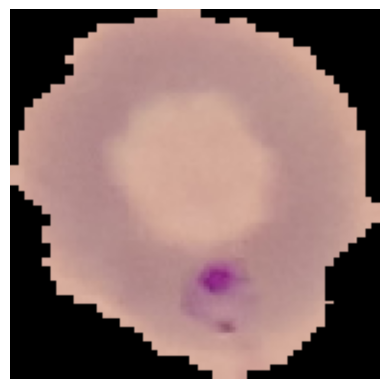

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_100.png


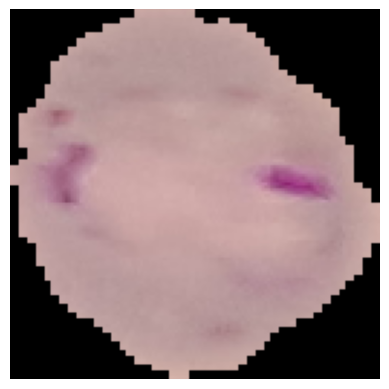

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_16.png


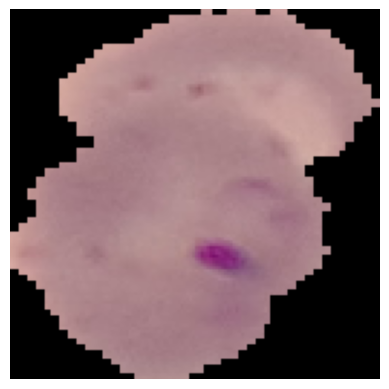

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_131.png


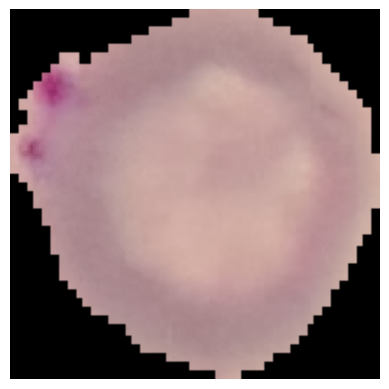

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_10.png


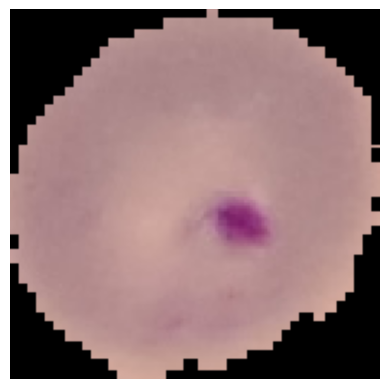

1/1 [==============================] - 0s 26ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_21.png


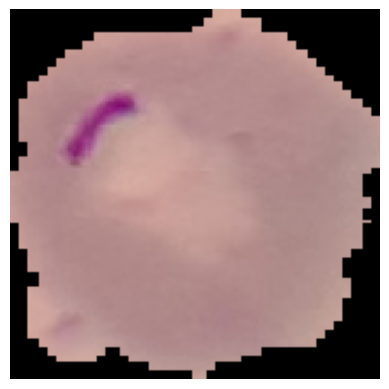

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_25.png


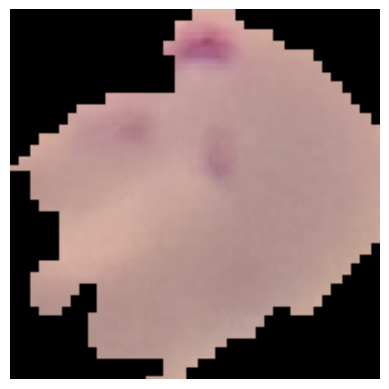

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_136.png


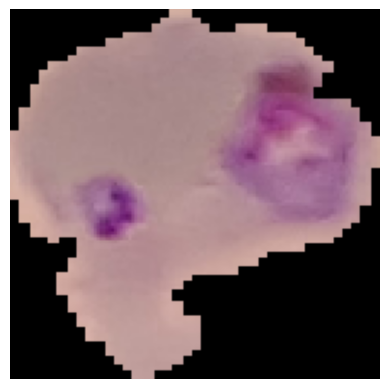

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_159.png


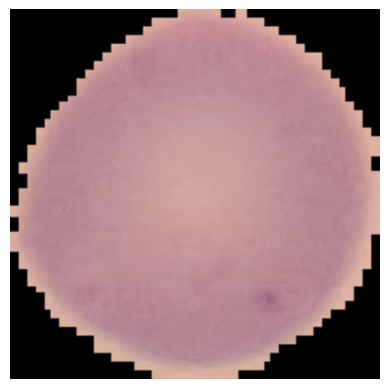

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_125.png


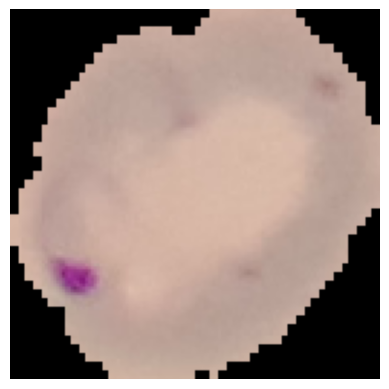

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_168.png


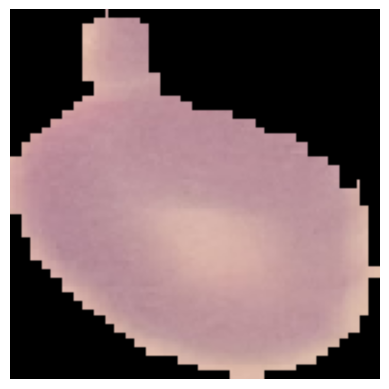

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_137.png


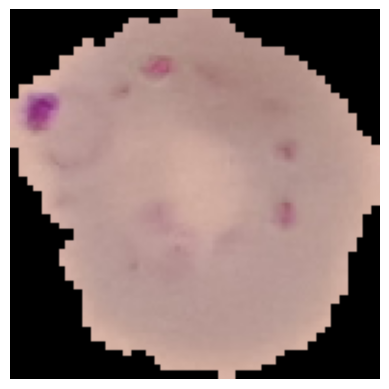

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_122.png


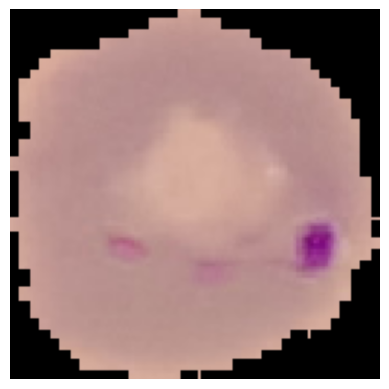

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_102.png


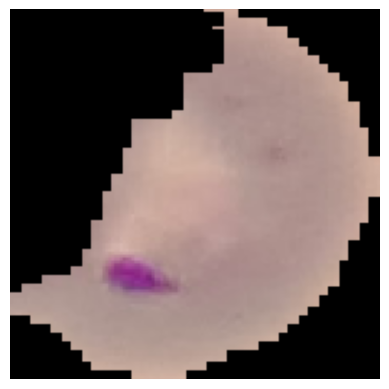

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_162922_cell_205.png


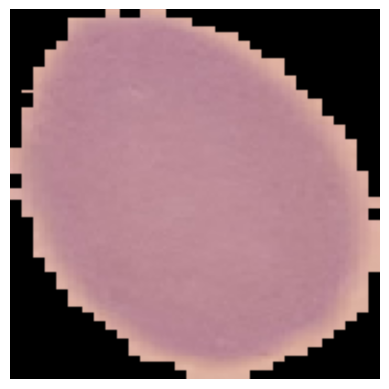

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_119.png


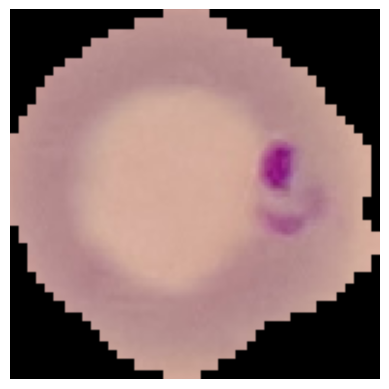

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_95.png


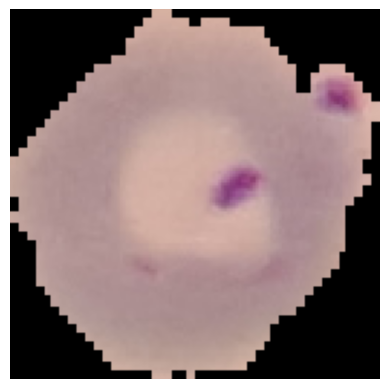

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_106.png


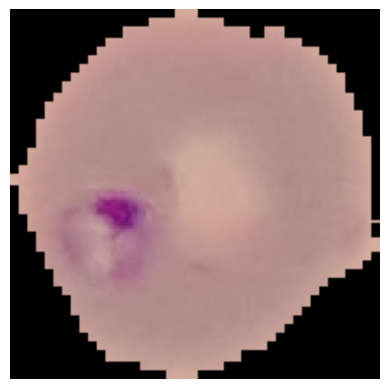

1/1 [==============================] - 0s 26ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_132.png


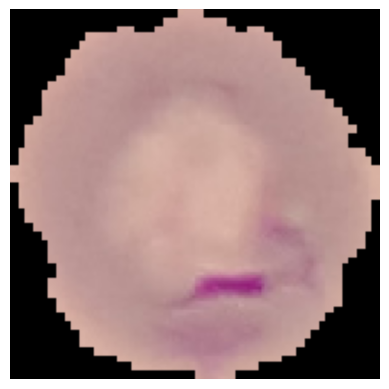

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_79.png


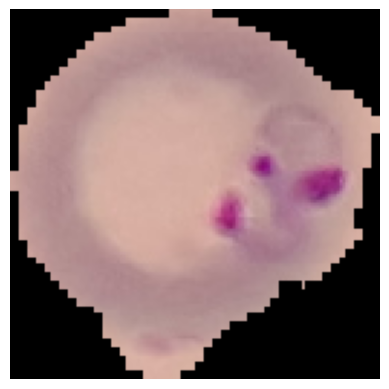

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110352_cell_80.png


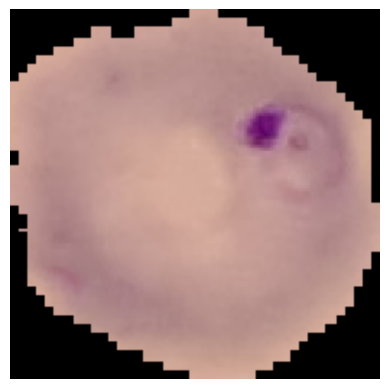

1/1 [==============================] - 0s 29ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_15.png


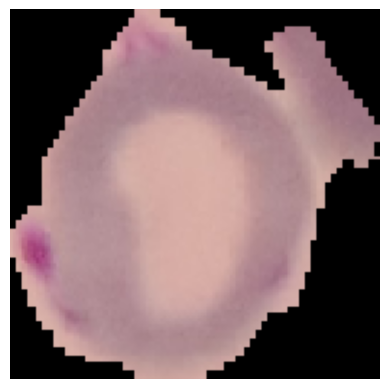

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_87.png


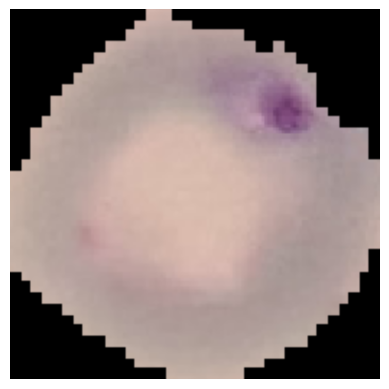

1/1 [==============================] - 0s 34ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_106.png


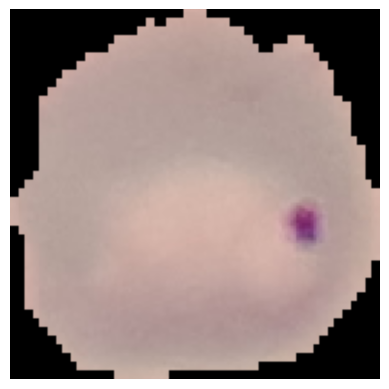

1/1 [==============================] - 0s 31ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_135.png


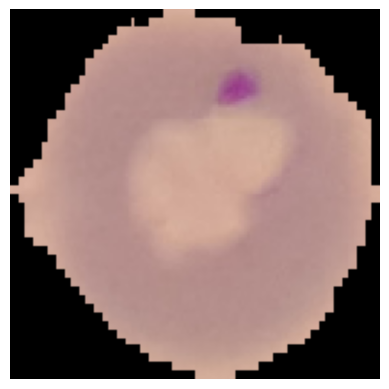

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_22.png


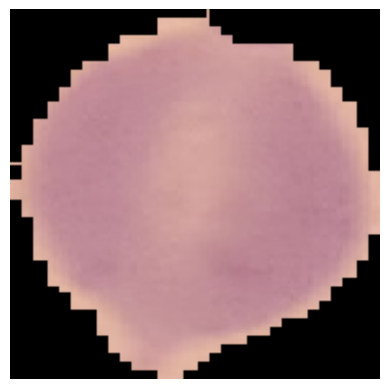

1/1 [==============================] - 0s 26ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_114.png


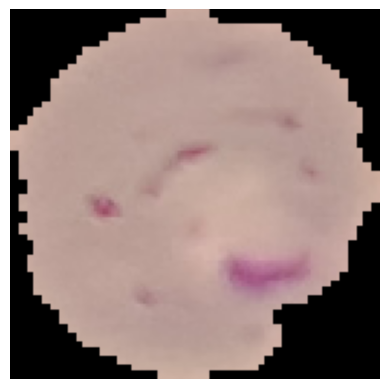

1/1 [==============================] - 0s 26ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_195.png


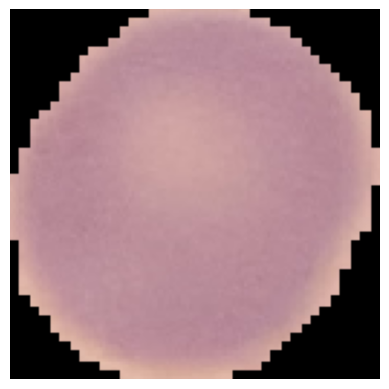

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_93.png


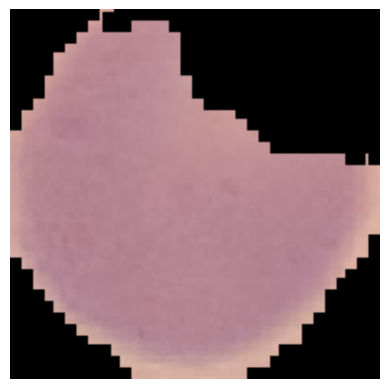

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_22.png


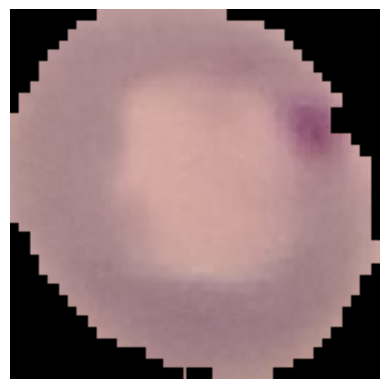

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_112.png


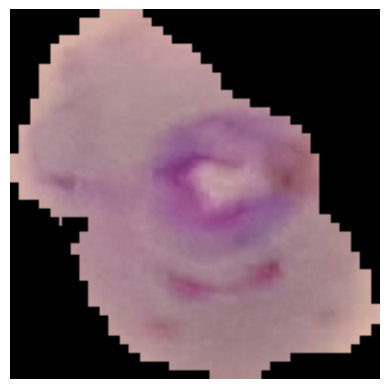

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_12.png


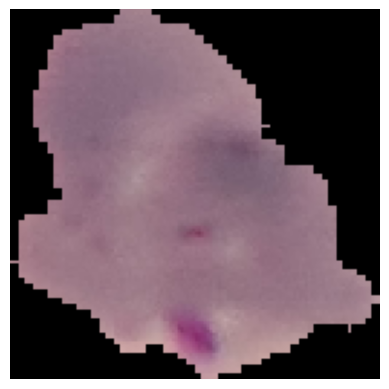

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_109.png


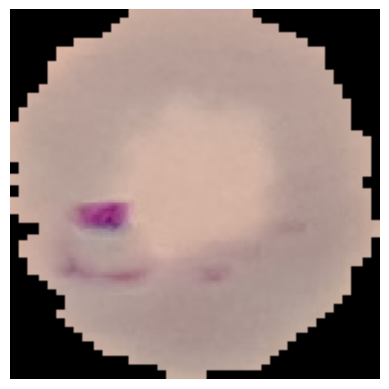

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_83.png


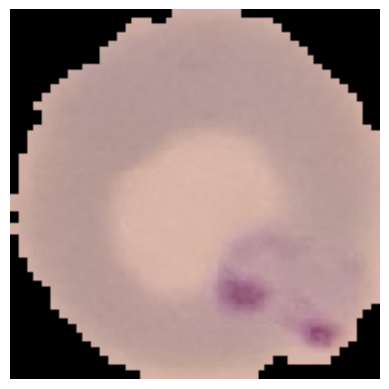

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_105.png


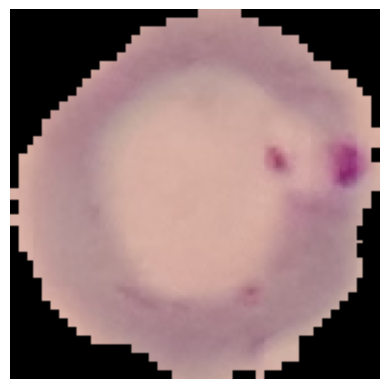

1/1 [==============================] - 0s 26ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_26.png


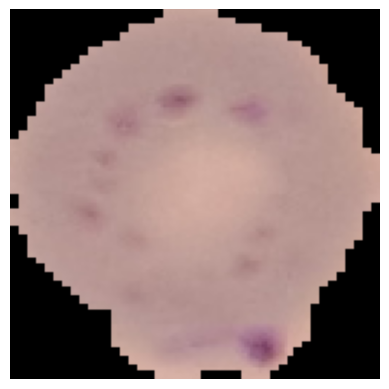

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_52.png


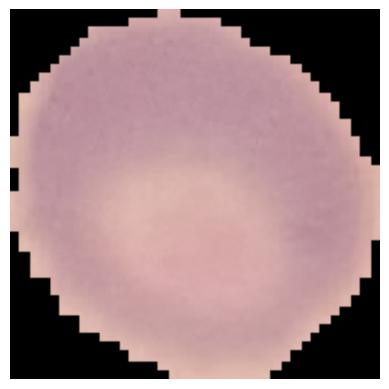

1/1 [==============================] - 0s 26ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_110.png


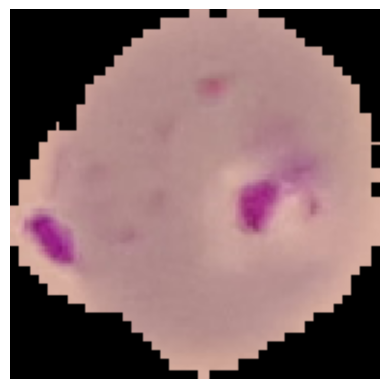

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_104.png


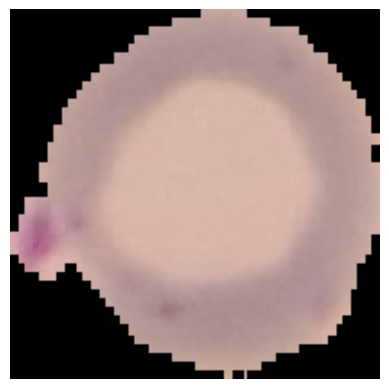

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_121.png


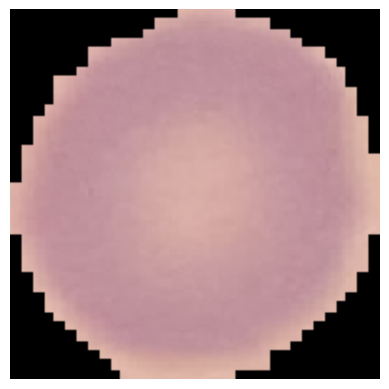

1/1 [==============================] - 0s 26ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_127.png


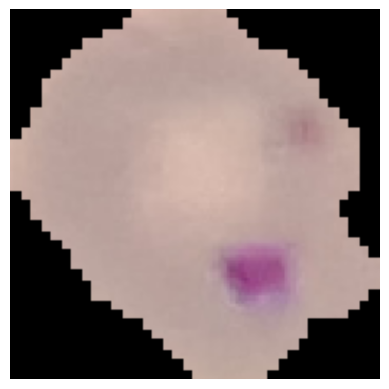

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_85.png


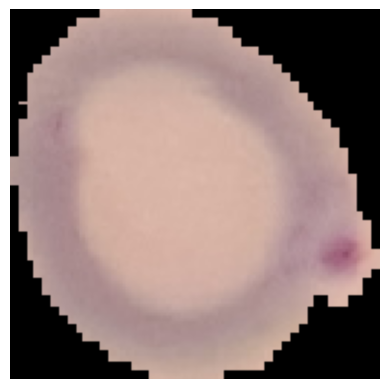

1/1 [==============================] - 0s 26ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_39.png


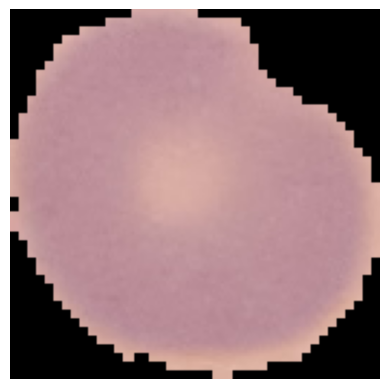

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_84.png


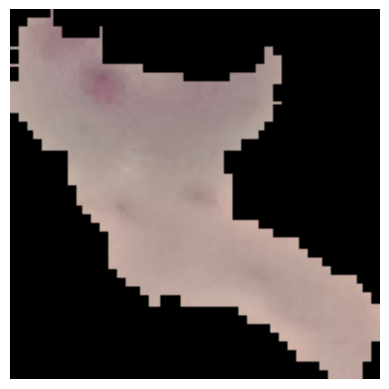

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_20.png


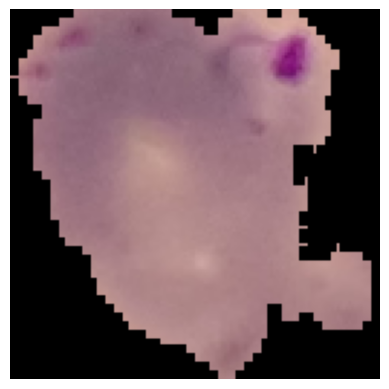

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_162922_cell_191.png


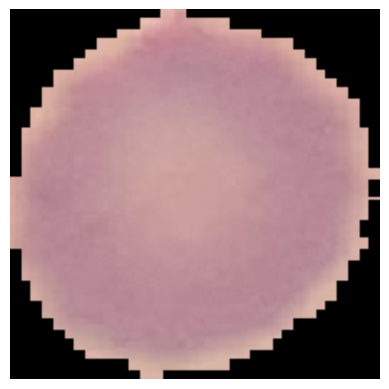

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_83.png


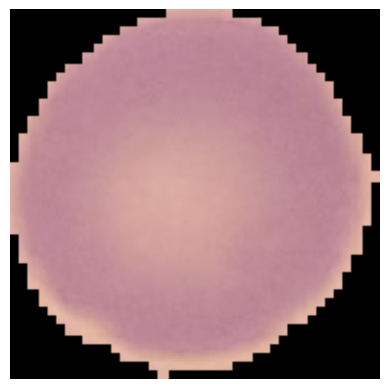

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163047_cell_183.png


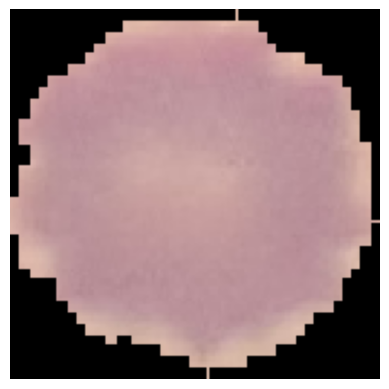

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110352_cell_79.png


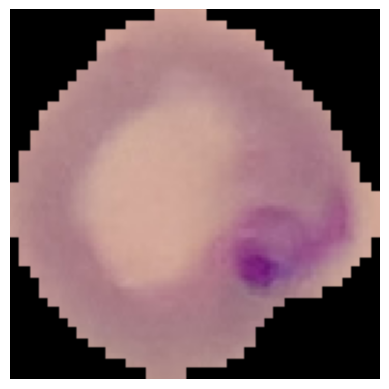

1/1 [==============================] - 0s 26ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_123.png


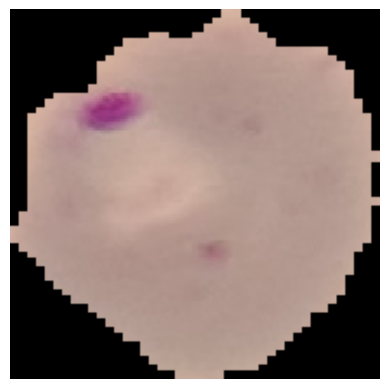

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_18.png


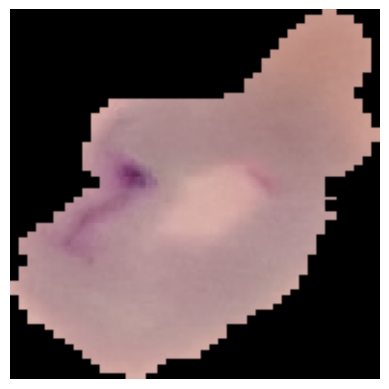

1/1 [==============================] - 0s 26ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_19.png


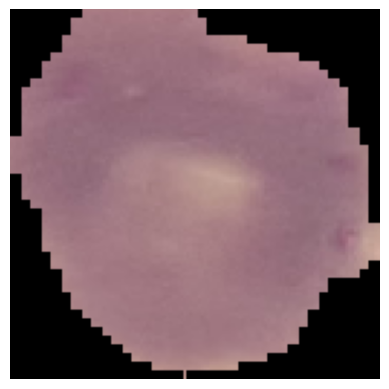

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_166.png


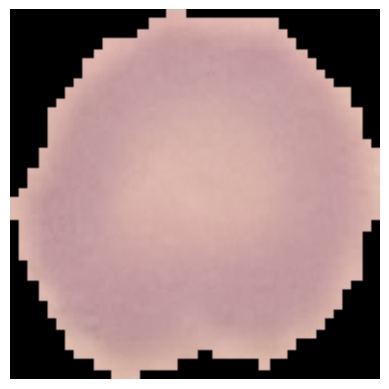

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_146.png


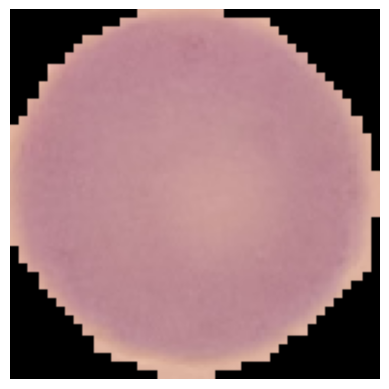

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_17.png


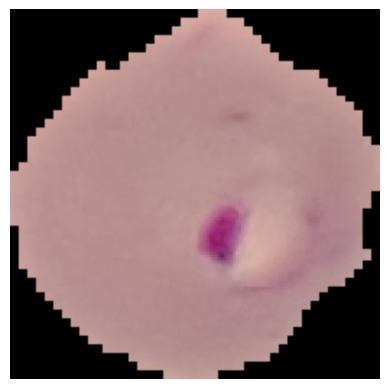

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163002_cell_78.png


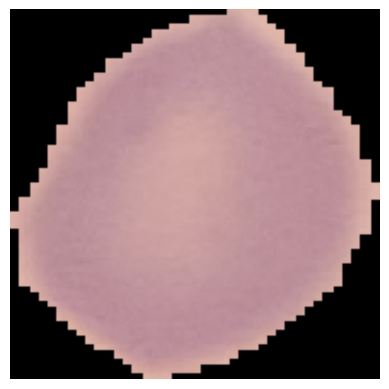

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_107.png


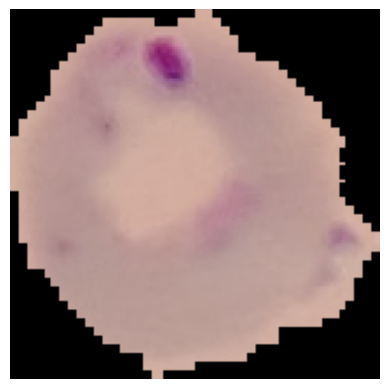

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163029_cell_125.png


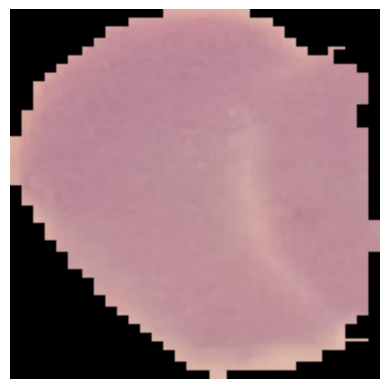

1/1 [==============================] - 0s 26ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_98.png


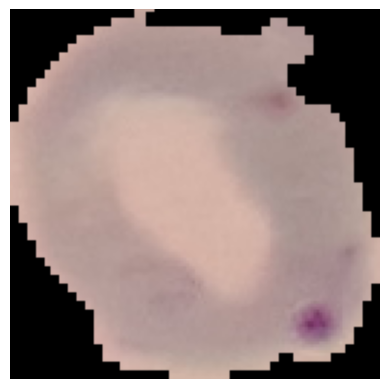

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_80.png


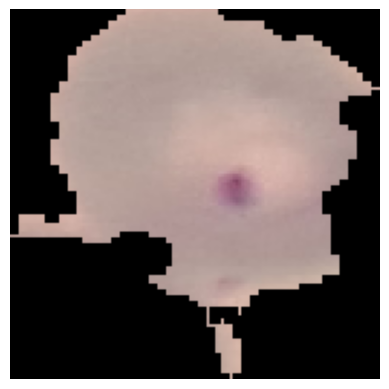

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_109.png


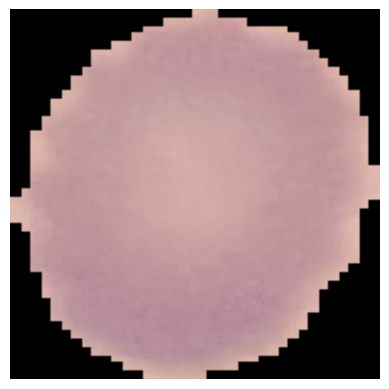

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_11.png


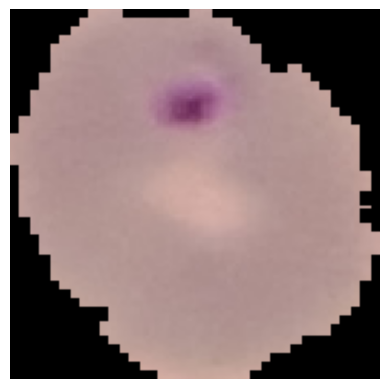

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_105.png


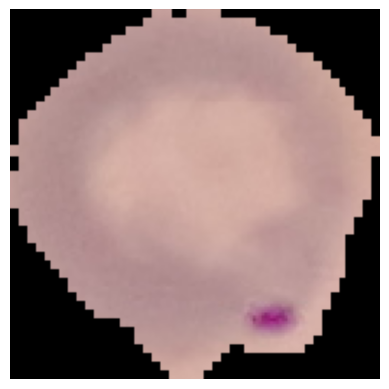

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_145.png


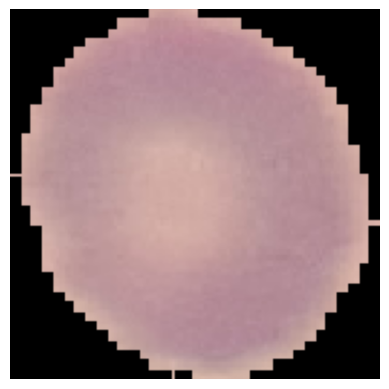

1/1 [==============================] - 0s 29ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_144.png


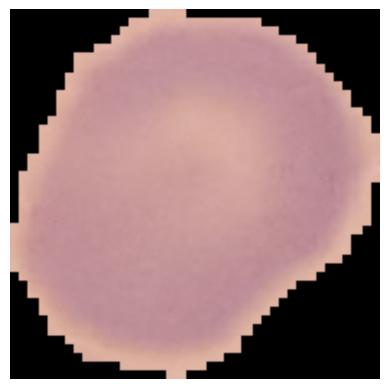

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163047_cell_161.png


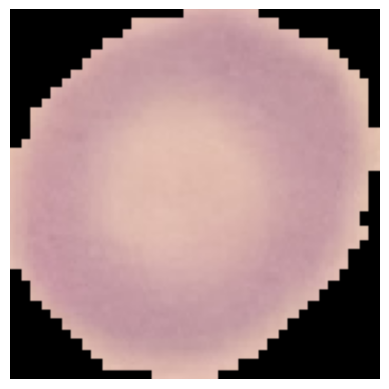

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_93.png


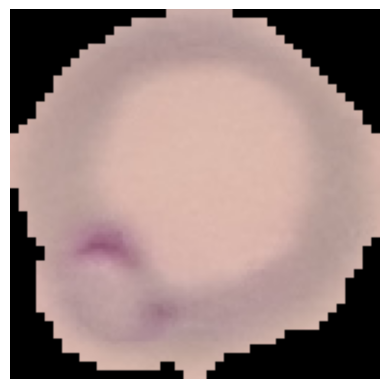

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_120.png


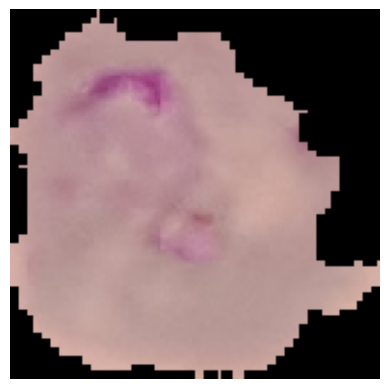

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_109.png


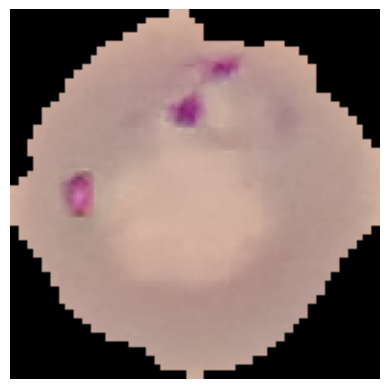

1/1 [==============================] - 0s 29ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_89.png


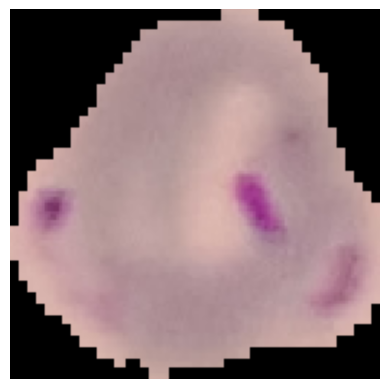

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_82.png


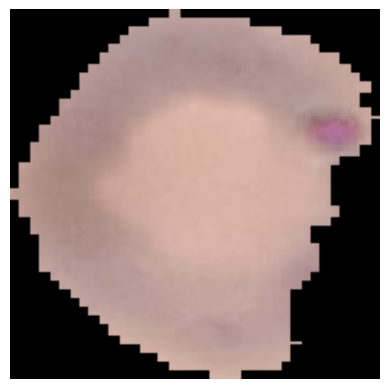

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_91.png


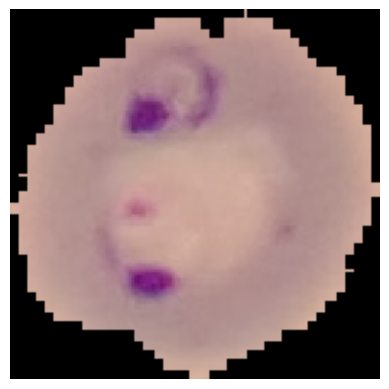

1/1 [==============================] - 0s 29ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_162922_cell_145.png


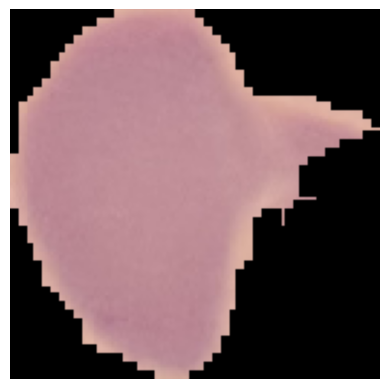

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_133.png


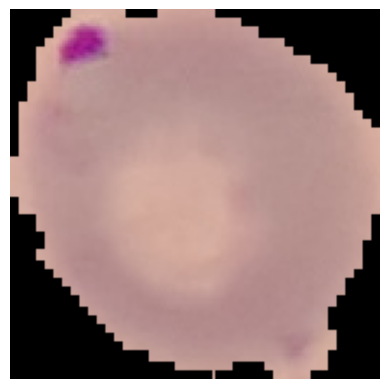

1/1 [==============================] - 0s 30ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_130.png


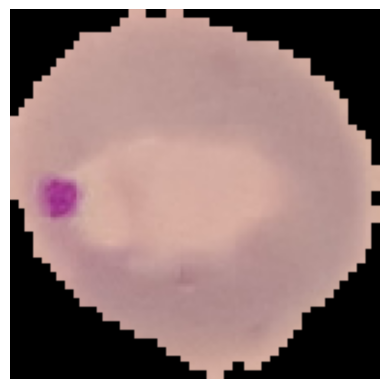

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_115.png


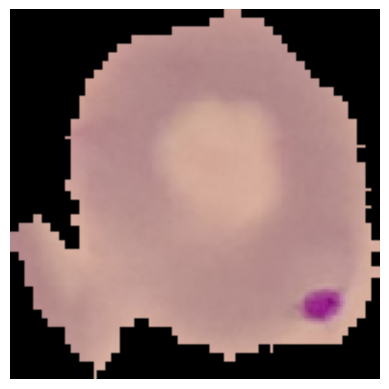

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_9.png


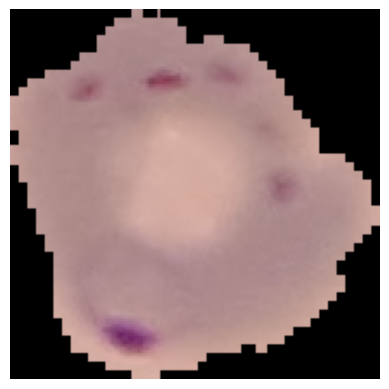

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_103.png


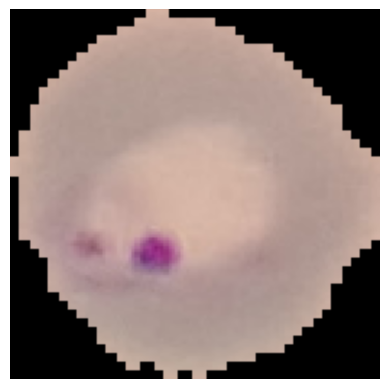

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_24.png


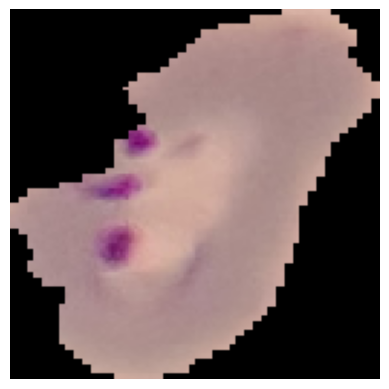

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_118.png


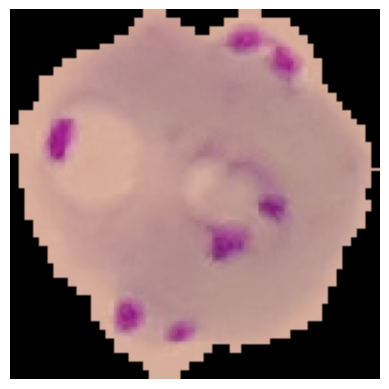

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_124.png


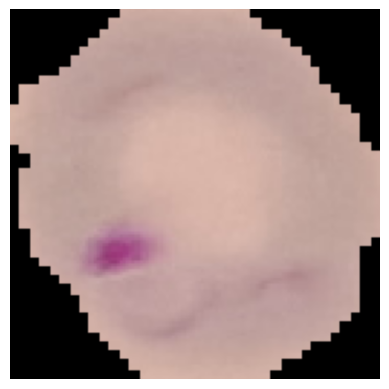

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105554_cell_23.png


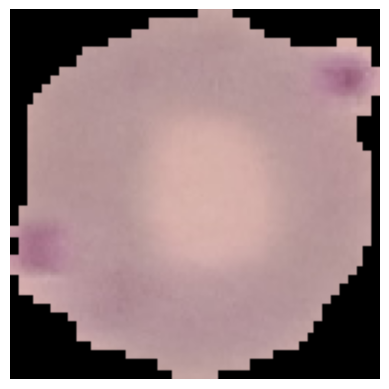

1/1 [==============================] - 0s 28ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_107.png


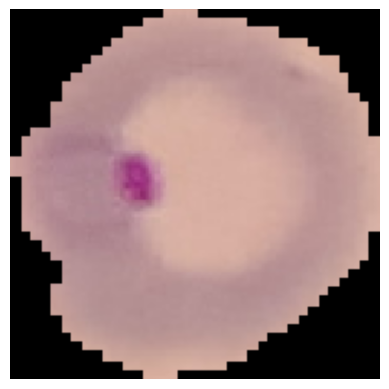

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_126.png


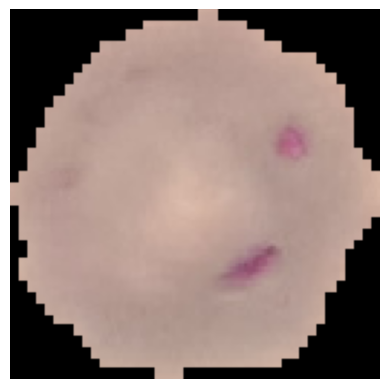

1/1 [==============================] - 0s 29ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_104.png


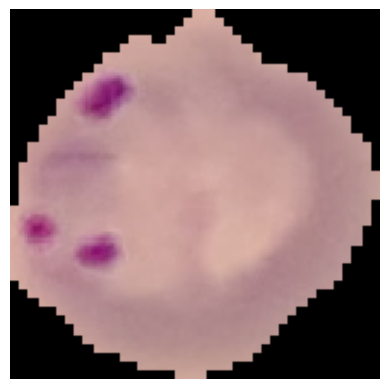

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_99.png


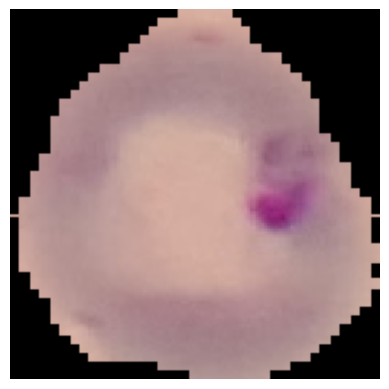

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_110115_cell_113.png


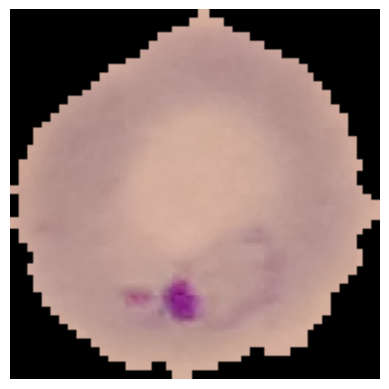

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_88.png


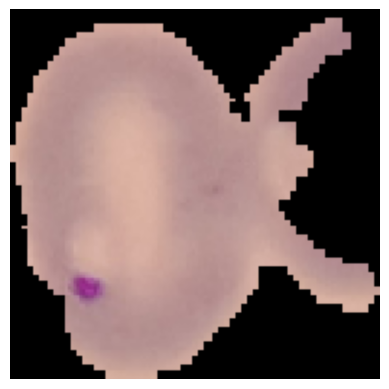

1/1 [==============================] - 0s 28ms/step
Predicted: infected

Processing image: C3thin_original_IMG_20150608_163047_cell_147.png


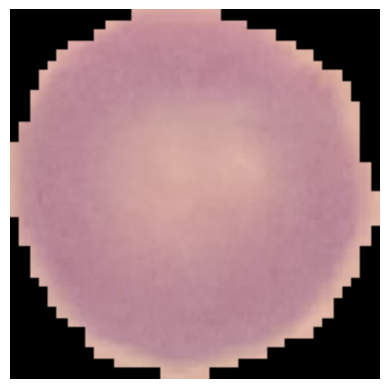

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_162922_cell_211.png


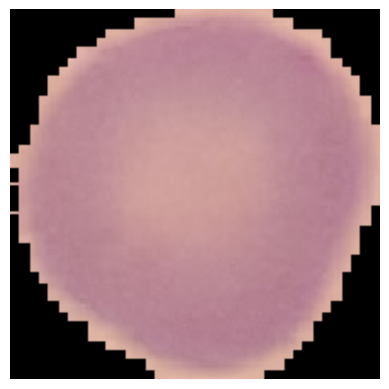

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163029_cell_202.png


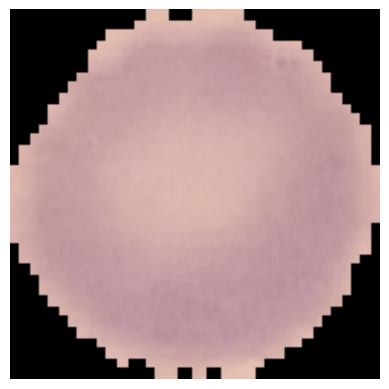

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_97.png


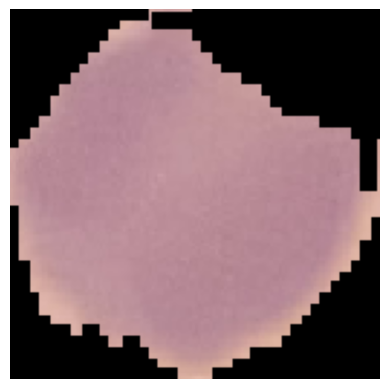

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Processing image: C3thin_original_IMG_20150608_163002_cell_81.png


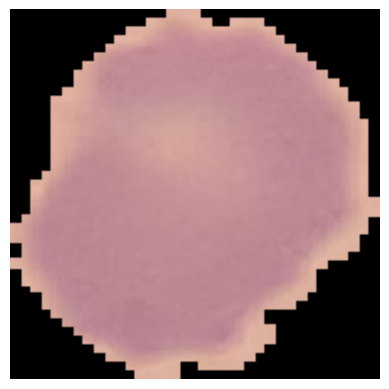

1/1 [==============================] - 0s 26ms/step
Predicted: uninfected

Processing image: C39P4thinF_original_IMG_20150622_105803_cell_78.png


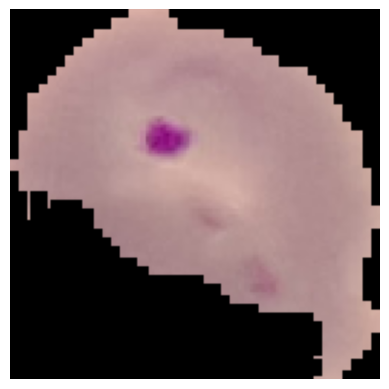

1/1 [==============================] - 0s 27ms/step
Predicted: infected

Processing image: 2.png


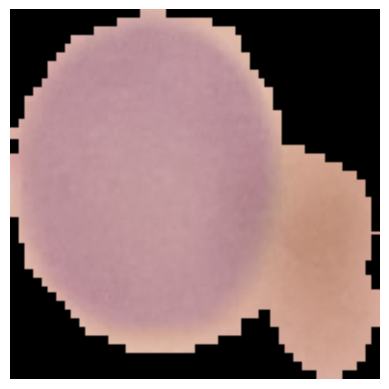

1/1 [==============================] - 0s 27ms/step
Predicted: uninfected

Summary of Results:
Image: C39P4thinF_original_IMG_20150622_105803_cell_112.png, Probability of being uninfected: 0.0060
Image: C3thin_original_IMG_20150608_163029_cell_220.png, Probability of being uninfected: 0.9784
Image: C39P4thinF_original_IMG_20150622_105803_cell_86.png, Probability of being uninfected: 0.2580
Image: C39P4thinF_original_IMG_20150622_105803_cell_101.png, Probability of being uninfected: 0.0256
Image: C39P4thinF_original_IMG_20150622_105803_cell_81.png, Probability of being uninfected: 0.0020
Image: C39P4thinF_original_IMG_20150622_110115_cell_121.png, Probability of being uninfected: 0.0064
Image: C39P4thinF_original_IMG_20150622_105803_cell_100.png, Probability of being uninfected: 0.0027
Image: C39P4thinF_original_IMG_20150622_105554_cell_16.png, Probability of being uninfected: 0.0074
Image: C39P4thinF_original_IMG_20150622_110115_cell_131.png, Probability of being uninfected: 0.1172
Ima

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


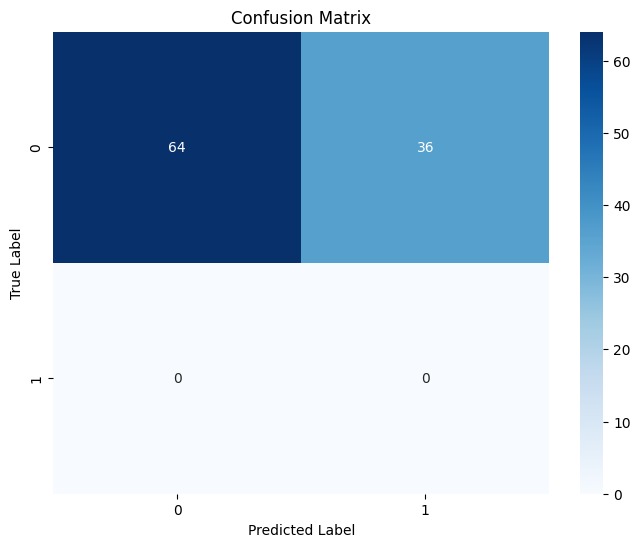

In [ ]:
# Function to predict and display results
def predict_and_display(model, img_path, target_size=(img_height, img_width)):
    try:
        # Load the image
        img = image.load_img(img_path, target_size=target_size)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        # Convert image to array and add batch dimension
        X = image.img_to_array(img)
        X = np.expand_dims(X, axis=0)

        # Normalize the image (consistent with training preprocessing)
        X = tf.cast(X, tf.float32)
        X = (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

        # Make prediction
        val = model.predict(X)

        prediction = "uninfected" if val[0][0] > 0.5 else "infected"
        print(f"Predicted: {prediction}")

        return val[0][0]
    except Exception as e:
        print(f"Error processing image {img_path}: {str(e)}")
        return None

# Rest of your code remains the same
# Get list of all images and randomly select 100
all_images = os.listdir(test_path)
selected_images = random.sample(all_images, min(100, len(all_images)))

# Process selected images
results = []
true_labels = []
for i in selected_images:
    img_path = os.path.join(test_path, i)
    print(f"\nProcessing image: {i}")
    probability = predict_and_display(model, img_path)
    if probability is not None:
        results.append({'image': i, 'probability': probability})
        # Assuming the true label is in the filename (e.g., "infected_001.png")
        true_label = 1 if "uninfected" in i.lower() else 0
        true_labels.append(true_label)

# Display summary of results
print("\nSummary of Results:")
for result in results:
    print(f"Image: {result['image']}, Probability of being uninfected: {result['probability']:.4f}")

# Calculate overall statistics
predicted_labels = [1 if r['probability'] > 0.5 else 0 for r in results]

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"\nTotal images processed: {len(results)}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

# Confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()